In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
import torch
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    GenerationConfig,
    set_seed
)
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import json
from tqdm import tqdm
from random import shuffle
from pprint import pprint
from functools import partial
import os
import random
import torch.nn.functional as F
import pandas as pd
import sys
sys.path.insert(0, '../../KGWatermark')
from extended_watermark_processor import WatermarkLogitsProcessor
from extended_watermark_processor import WatermarkDetector
from transformers import LogitsProcessorList
from transformers import GenerationConfig

In [ ]:
compute_dtype = getattr(torch, "float16")
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=False,
    )

config = LoraConfig(
    r=16, #Rank
    lora_alpha=32,
    target_modules=[
        'q_proj',
        'k_proj',
        'v_proj',
        'o_proj',
        'gate_proj',
        'up_proj',
        'down_proj',
        'dense'
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)


model_name = 'mistralai/Mistral-7B-v0.1'
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left", add_eos_token=True, add_bos_token=True)
tokenizer.pad_token = tokenizer.eos_token

original_model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit = True,
                                                      device_map = 'auto'
                                                     )
print(f"Model's on {original_model.device}")

watermark_processor = WatermarkLogitsProcessor(vocab=list(tokenizer.get_vocab().values()),
                                               gamma=0.25,
                                               delta=2.0,
                                               seeding_scheme="selfhash") #equivalent to `ff-anchored_minhash_prf-4-True-15485863`

In [ ]:
def load_json_file(file_path):
    """
    Load json file
    """
    with open(file_path,'r',encoding='utf-8') as f:
        file = json.load(f)
        f.close()
    return file

def save_json_file(file, file_path):
    """
    Save json file
    """
    with open(file_path,'w',encoding='utf-8') as f:
        json.dump(file, f, indent=4, ensure_ascii=False)
        f.close()

def gen(model, prompt, max_length, temperature = 0.35, watermark = None):
    generation_config = GenerationConfig(
        max_new_tokens = max_length,
        repetition_penalty = 1.0,
        do_sample = True,
        #  num_beams = 5,
        temperature = temperature,
        # num_return_sequences=5,
        early_stopping=True, 
        no_repeat_ngram_size=4, 
        pad_token_id=tokenizer.eos_token_id)

    model_inputs = tokenizer(prompt, padding=True, truncation=True, return_tensors="pt",max_length=1024)
    # print(model_inputs['attention_mask'])
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_inputs.to(device)
    if watermark is not None:
        outputs = model.generate(**model_inputs,
                                 logits_processor = LogitsProcessorList([watermark_processor]),
                             generation_config = generation_config)
    else:
        outputs = model.generate(**model_inputs,
                             generation_config = generation_config)
    result = []
    for item in outputs:
        # print(item)
        result.append(tokenizer.decode(item, skip_special_tokens=True))
    return result

In [ ]:
# prompt = ['how are you today', "how's the weather today?"]
result = gen(original_model, 'Introduce Berkeley to me in general', 500)


In [ ]:
watermark_detector = WatermarkDetector(vocab=list(tokenizer.get_vocab().values()),
                                        gamma=0.25, # should match original setting
                                        seeding_scheme="selfhash", # should match original setting
                                        device = device, # must match the original rng device type
                                        tokenizer=tokenizer,
                                        z_threshold=4.0,
                                        normalizers=[],
                                        ignore_repeated_ngrams=True)

watermarked_score_dict = watermark_detector.detect(result) # or any other text of interest to analyze
print(f"Watermark's result: {watermarked_score_dict['prediction']}")

In [ ]:
text = 'You motherfucker is a son of bitch, your whole family are cunt and robberies '
_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt', max_length = 300)
device = 'cuda'
_input.to(device)
outputs = original_model.generate(**_input, max_new_tokens=100,
                                 repetition_penalty = 1.0,
                                 do_sample = True,
                                #  num_beams = 5,
                                 temperature = 0.7,
                                 # num_return_sequences=5,
                                 early_stopping=True, 
                                 no_repeat_ngram_size=4, 
                                 pad_token_id=tokenizer.eos_token_id)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
def calculate_entropy(logits):
    probabilities = F.softmax(logits, dim=-1)
    log_probabilities = F.log_softmax(logits, dim=-1)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1)
    return entropy

input_text = 'I amоmеd to have been invited to be a speaker at the 3rd International Conference on 5G and Internet of Things (IoT) in the Smart City, on 23-24 September 2020.'
_input = tokenizer(input_text, padding = True, truncation = True, return_tensors = 'pt', max_length = 30)
total_logits = original_model(**_input).logits
logits_lenth = total_logits.shape[1]
_input['input_ids']

for i in range(0, len(_input['input_ids'])):
    entropy = calculate_entropy(total_logits)
    print(f"Entropy at position {i} is {entropy}")

assert entropy.shape[-1] == logits_lenth, f"entropy's length is {entropy.shape[-1]}, while logits' length is {logits_lenth}"

average_entropy = torch.mean(entropy, dim=-1)
print(f"Average entropy is {average_entropy}")

In [104]:
def calculate_entropy(tokenizer, input_text, model):
    _input = tokenizer(input_text, padding = True, truncation = True, return_tensors = 'pt', max_length = 30)
    logits = model(**_input).logits.detach()
    probabilities = F.softmax(logits, dim=-1)
    log_probabilities = F.log_softmax(logits, dim=-1)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1).detach().cpu()
    average_entropy = torch.mean(entropy, dim=-1)
    assert entropy.shape[-1] == logits.shape[1], f"entropy's length is {entropy.shape[-1]}, while logits' length is {logits.shape[1]}"
    return entropy, average_entropy

def generate_random_words(tokenizer, n=5):
    size = (1, n)
    vocab_length = len(tokenizer.get_vocab())
    # Generate a random word length between 3 and 8 characters
    word_indice = torch.randint(low = 0, high = vocab_length, size = size)
    # print(word_indice)
    gen_words = tokenizer.decode(word_indice[0], skip_special_tokens=True)
    # print(' '.join(word for word in tokenizer.convert_ids_to_tokens(word_indice[0]))) # This method will have _ within
    # print(word_list)
    return gen_words


def generate_random_english_sentence(tokenizer, n=5):
    # Filter the tokenizer's vocabulary to only English words
    english_vocab = {k: v for k, v in tokenizer.get_vocab().items() if k.isascii() and not k.startswith('##') and k.islower()}
    
    # Create a list of just the English word indices
    english_vocab_indices = list(english_vocab.values())
    
    # Generate random indices
    random_indices = torch.randint(low=0, high=len(english_vocab_indices), size=(n,))
    
    # Map the random indices to the English word indices
    word_indices = [english_vocab_indices[i] for i in random_indices.numpy()]
    
    # Decode the word indices to get the words and join them to form a sentence
    random_words = [tokenizer.decode([idx], skip_special_tokens=True) for idx in word_indices]
    sentence = ' '.join(random_words)
    
    return sentence

vocab = tokenizer.vocab

input_text = generate_random_words(len(vocab), 10)
prefix = '''I want you to repeat the following sentence: {content}. [Output]'''.format(content = input_text)
revised_text = prefix + input_text
print(f"Original sentence: {input_text}")
print(f"Revised sentence: {revised_text}")
# input_text = 'Good mourning'

AttributeError: 'int' object has no attribute 'get_vocab'

In [ ]:
import copy
def display_bar_chart(numbers, color = 'blue'):
    # Sort the numbers and retain the sorted indices
    sorted_indices, sorted_numbers = zip(*sorted(enumerate(numbers), key=lambda x: x[1], reverse=True))
    plt.figure(figsize=(20, 5))  # Increase figure size
    # Plot the sorted data
    plt.bar(range(len(sorted_numbers)), sorted_numbers, color=color)
    # plt.xticks(range(len(sorted_indices)), sorted_indices,rotation=45)  # Set the x-ticks to show the original indices
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Chart')
    plt.show()

Evaluating: 100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


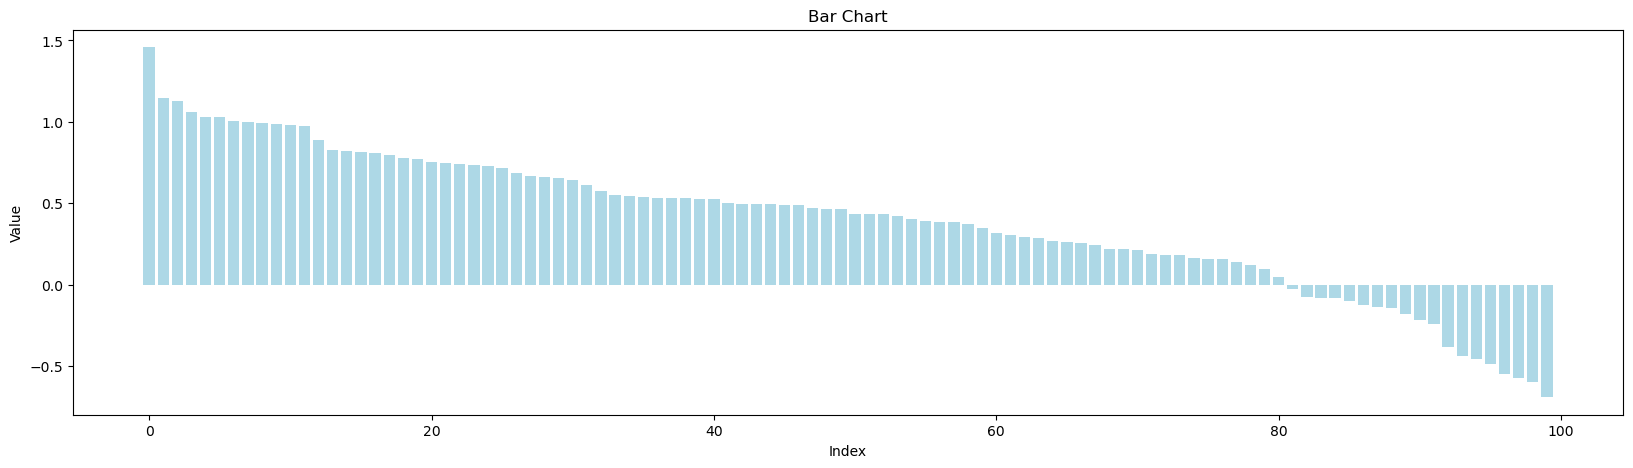

count    100.000000
mean       0.395584
std        0.439439
min       -0.692510
25%        0.163120
50%        0.448961
75%        0.718055
max        1.458576
dtype: float64


Evaluating: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


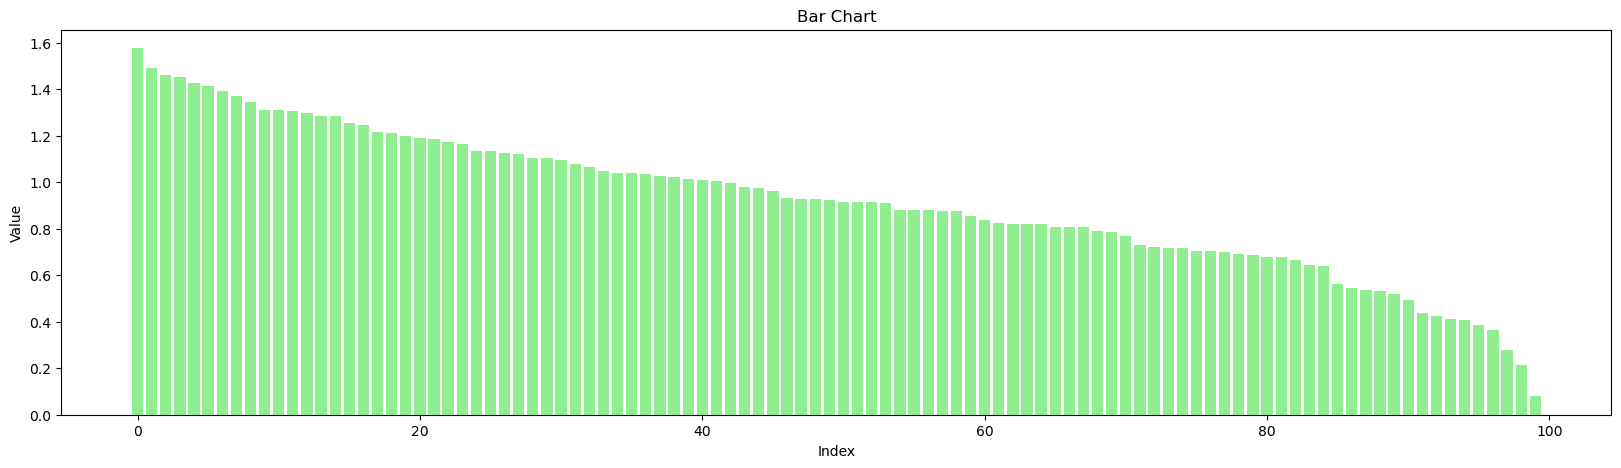

count    100.000000
mean       0.920340
std        0.309546
min        0.080731
25%        0.713989
50%        0.919276
75%        1.133796
max        1.576534
dtype: float64


Evaluating: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


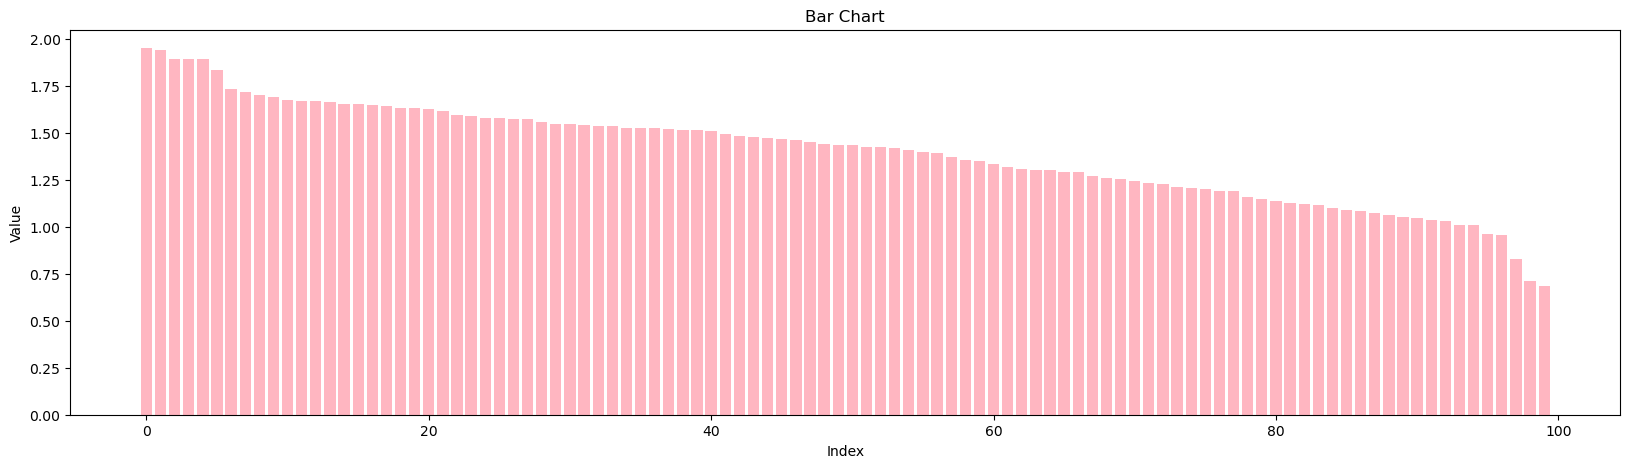

count    100.000000
mean       1.399128
std        0.265769
min        0.687084
25%        1.206213
50%        1.438491
75%        1.581237
max        1.952881
dtype: float64


In [103]:
def entropy_deduction_eval(sentence_generator, tokenizer, test_number, test_length):
    diminished_avg_entropy = []
    for i in tqdm(range(test_number), desc='Evaluating'):
        input_text = sentence_generator(tokenizer, test_length)
        revised_text = prefix + input_text
        original_entropy, original_average_entropy = calculate_entropy(tokenizer, input_text, original_model)
        revised_entropy, revised_average_entropy = calculate_entropy(tokenizer, revised_text, original_model)
        # print(f"Original average entropy is {original_average_entropy}, revised average entropy is {revised_average_entropy}")
        # print(f"Revised average entropy is {revised_average_entropy}, original average entropy is {original_average_entropy}")
        diminished_avg_entropy.append(original_average_entropy - revised_average_entropy)
    return diminished_avg_entropy

lengths = [5, 10, 20]
colors = ['lightblue','lightgreen','lightpink']
prefix_entropy_reduction = dict()
for length, color in zip(lengths, colors):
    diminished_avg_entropy = entropy_deduction_eval(generate_random_words,tokenizer=tokenizer, test_number=100, test_length = length)
    to_t = lambda array: torch.tensor(array, device=device, dtype=torch.float32)
    from_t = lambda tensor: tensor.to('cpu').detach().numpy()
    backup = copy.deepcopy(diminished_avg_entropy)
    diminished_avg_entropy = list(map(lambda x: float(x), diminished_avg_entropy))
    prefix_entropy_reduction[length] = diminished_avg_entropy
    display_bar_chart(diminished_avg_entropy, color)
    pd_avg_entropy = pd.Series(diminished_avg_entropy)
    summary = pd_avg_entropy.describe()
    print(summary)

In [ ]:
def watermarked_random_sentence_entropy(tokenizer, test_number, test_length):
    diminished_avg_entropy = []
    input_list = []
    normal_response_list = []
    watermarked_response_list = []
    for i in tqdm(range(test_number), desc='Evaluating'):
        input_text = generate_random_english_sentence(tokenizer, test_length)
        template = '''Only repeat the following sentence and stop: {content}. [Output]'''.format(content = input_text)
        _input = template.format(content = input_text)
        # print(f"Original sentence: {_input}")
        # print('-'*100)
        input_list.append(_input)
        normal_response = gen(original_model, _input, 100, temperature=0.1)
        watermarked_response = gen(original_model, _input, 100, watermark = watermark_processor, temperature=0.1)
        normal_response_list.append(normal_response)
        watermarked_response_list.append(watermarked_response)
        # pprint(f"Normal response: {normal_response}")
        # pprint(f"Watermarked response: {watermarked_response}")
        # break
        original_entropy, original_average_entropy = calculate_entropy(tokenizer, normal_response, original_model)
        revised_entropy, revised_average_entropy = calculate_entropy(tokenizer, watermarked_response, original_model)
        # print(f"Original average entropy is {original_average_entropy}, revised average entropy is {revised_average_entropy}")
        # print(f"Revised average entropy is {revised_average_entropy}, original average entropy is {original_average_entropy}")
        diminished_avg_entropy.append(original_average_entropy - revised_average_entropy)
    return diminished_avg_entropy, input_list, normal_response_list, watermarked_response_list

diminished_avg_entropy, input_list, normal_response_list, watermarked_response_list = watermarked_random_sentence_entropy(tokenizer, 20, 10)
pprint(diminished_avg_entropy)

In [94]:
dataset = load_dataset("allenai/c4", "realnewslike")

Using the latest cached version of the dataset since allenai/c4 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'realnewslike' at /home/ShenChenchen/.cache/huggingface/datasets/allenai___c4/realnewslike/0.0.0/1588ec454efa1a09f29cd18ddd04fe05fc8653a2 (last modified on Tue Mar 26 12:00:09 2024).


In [ ]:
dataset['validation']

In [ ]:
# pprint(dir(original_model(_input['input_ids'])))
print(len(_input['input_ids'][0]))
print(_input['input_ids'])
pprint(original_model(_input['input_ids']).logits[0,:,0])
nlogit = original_model(_input['input_ids']).logits[:,-2,:]

In [ ]:
for i in range(len(original_model(_input['input_ids']).logits[0,:,0])):
    nlogit = original_model(_input['input_ids']).logits[:,i,:]
    result = tokenizer.convert_ids_to_tokens(torch.topk(nlogit, 10).indices.tolist()[0])
    print(result)
    print('='*10)



In [ ]:
batch_input = torch.cat((_input['input_ids'], _input['input_ids']), dim = 0)
batch_input = torch.cat((batch_input, _input['input_ids']), dim = 0)
batch_input
batch_output = original_model(batch_input).logits
batch_output.shape

In [ ]:
import torch

# Assuming original_tensor is your existing tensor with shape (1, 7)
original_tensor = torch.tensor([[1, 910, 460, 368, 3154, 28804, 2]], device='cuda:0')

# Assuming new_tensor is the tensor you want to add, also with shape (1, 7)
# For demonstration, let's create a new tensor with some values. Adjust as necessary.
new_tensor = torch.tensor([[2, 911, 461, 369, 3155, 28805, 3]], device='cuda:0')

# Concatenate along the first dimension (dim=0)
final_tensor = torch.cat((original_tensor, new_tensor), dim=0)

print(final_tensor)
print("Shape of the final tensor:", final_tensor.shape)

tokenizer.convert_ids_to_tokens(_input['input_ids'].tolist()[0])


In [ ]:
import torch
tensor = torch.arange(24).reshape(2, 3, 4)
print(tensor)
print(tensor.shape)

# Sum over dim=0
sum_dim0 = torch.sum(tensor, dim=0)
print("Sum over dim=0:", sum_dim0, "\nShape:", sum_dim0.shape)

# Sum over dim=1
sum_dim1 = torch.sum(tensor, dim=1)
print("Sum over dim=1:", sum_dim1, "\nShape:", sum_dim1.shape)

# Sum over dim=2
sum_dim2 = torch.sum(tensor, dim=2)
print("Sum over dim=2:", sum_dim2, "\nShape:", sum_dim2.shape)


In [ ]:
# Concatenate along dim=0
cat_dim0 = torch.cat((tensor, tensor), dim=0)
print("Concatenated along dim=0, shape:", cat_dim0.shape)

# Concatenate along dim=1
cat_dim1 = torch.cat((tensor, tensor), dim=1)
print("Concatenated along dim=1, shape:", cat_dim1.shape, cat_dim1)

# Concatenate along dim=2
cat_dim2 = torch.cat((tensor, tensor), dim=2)
print("Concatenated along dim=2, shape:", cat_dim2.shape)


In [ ]:
import torch

# Creating a 2D tensor for demonstration
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10,11,12]])

# Get max along rows (dim=1)
max_values_row, indices_row = torch.max(tensor, dim=1)
print("Max values along rows:", max_values_row)
print("Indices of max values along rows:", indices_row)

# Get max along columns (dim=0)
max_values_col, indices_col = torch.max(tensor, dim=0)
print("\nMax values along columns:", max_values_col)
print("Indices of max values along columns:", indices_col)


In [ ]:
import torch

def check_gpu_status():
    if torch.cuda.is_available():
        device = torch.cuda.get_device_name(0)
        print(f"GPU: {device}")
    else:
        print("No GPU available")
check_gpu_status()
